# Language Model analysis

In [1]:
import pandas as pd
import time
import matplotlib.pyplot as plt
import numpy as np

from gensim.models import Word2Vec
from gensim import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [2]:
# embedding models, base model
#model_path = "/Users/khosseini/myJobs/ATI/Projects/2019/Living-with-Machines-code/language-lab-mro/lexicon_expansion/interactive_expansion/models/all_books/w2v_005/w2v_words.model"
model_path = "./LMs/embedding_model_scratch_corrected.model"
w2v_corrected = Word2Vec.load(model_path)

2019-11-21 11:36:42,747 : INFO : loading Word2Vec object from ./LMs/embedding_model_scratch_corrected.model
2019-11-21 11:36:43,185 : INFO : loading wv recursively from ./LMs/embedding_model_scratch_corrected.model.wv.* with mmap=None
2019-11-21 11:36:43,186 : INFO : loading vectors from ./LMs/embedding_model_scratch_corrected.model.wv.vectors.npy with mmap=None
2019-11-21 11:36:43,297 : INFO : setting ignored attribute vectors_norm to None
2019-11-21 11:36:43,299 : INFO : loading vocabulary recursively from ./LMs/embedding_model_scratch_corrected.model.vocabulary.* with mmap=None
2019-11-21 11:36:43,299 : INFO : loading trainables recursively from ./LMs/embedding_model_scratch_corrected.model.trainables.* with mmap=None
2019-11-21 11:36:43,300 : INFO : loading syn1neg from ./LMs/embedding_model_scratch_corrected.model.trainables.syn1neg.npy with mmap=None
2019-11-21 11:36:43,406 : INFO : setting ignored attribute cum_table to None
2019-11-21 11:36:43,406 : INFO : loaded ./LMs/embeddin

In [3]:
def found_neighbors(myrow, embedding, colname='vocab', topn=1):
    try:
        vocab_neigh = embedding.wv.most_similar([myrow['vocab']], topn=topn)
        return list(np.array(vocab_neigh)[:, 0])
    except KeyError:
        return []

In [4]:
def jaccard_similarity_df(myrow, colname_1, colname_2, num_items=False, make_lowercase=True):
    """
    Jaccard similarity between two documents (e.g., OCR and Human) on flattened list of words
    """
    if not num_items:
        list1 = myrow[colname_1]
        list2 = myrow[colname_2]
    else:
        list1 = myrow[colname_1][:num_items]
        list2 = myrow[colname_2][:num_items]
    if make_lowercase:
        list1 = [x.lower() for x in list1]
        list2 = [x.lower() for x in list2]
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection
    return float(intersection) / union

In [5]:
words_corrected = []
for item in w2v_corrected.wv.vocab:
    words_corrected.append([item, int(w2v_corrected.wv.vocab[item].count)])

In [6]:
pd_words = pd.DataFrame(words_corrected, columns=['vocab', 'count'])

In [7]:
pd_words = pd_words.sort_values(by=['count'], ascending=False)
print("size: {}".format(len(pd_words)))
pd_words.head()

size: 179735


,vocab,count
57,",",860225
24,.,831221
21,the,736361
5,of,351214
110,and,291173


In [8]:
pd2search = pd_words[0:1000]
pd2search

,vocab,count
57,",",860225
24,.,831221
21,the,736361
5,of,351214
110,and,291173
...,...,...
2483,matches,1142
8638,cape,1140
2883,matters,1139
265,prince,1139


# Quality bands 1, 2

In [9]:
start_run = input("This will take a long time! Continue? (y/n)")

if start_run == 'y':
    neigh_jaccard_bands_1_2 = []

    for i_model in range(0, 50):

        w2v_em_corr_qual_1_2 = Word2Vec.load('./LMs/w2v_005_EM_corr_qual_1_2_%05i.model' % i_model)
        w2v_em_ocr_qual_1_2 = Word2Vec.load('./LMs/w2v_005_EM_ocr_qual_1_2_%05i.model' % i_model)

        #for topn in [1, 2, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000]:
        for topn in [50000]:
            print("topn: {}".format(topn))
            t1 = time.time()

            pd2search = pd_words[0:1000]
            pd2search['w2v_em_corr_qual_1_2'] = pd2search.apply(found_neighbors, args=[w2v_em_corr_qual_1_2, 
                                                                                       'vocab', 
                                                                                       topn], axis=1)
            print("corr: {}".format(time.time() - t1))
            pd2search['w2v_em_ocr_qual_1_2'] = pd2search.apply(found_neighbors, args=[w2v_em_ocr_qual_1_2,
                                                                                      'vocab', 
                                                                                      topn], axis=1)
            print("ocr: {}".format(time.time() - t1))

        mytopn_range = [1, 2, 5, 
                        10, 20, 50, 
                        100, 200, 500, 
                        1000, 2000, 5000, 
                        10000, 20000, 50000]
        for mytopn in mytopn_range:
            pd2search['jaccard_qual_1_2'] = \
                pd2search.apply(jaccard_similarity_df, 
                                args=['w2v_em_corr_qual_1_2', "w2v_em_ocr_qual_1_2", mytopn], 
                                axis=1)

            neigh_jaccard_bands_1_2.append(
                [mytopn, 
                 pd2search['jaccard_qual_1_2'].mean(), 
                 pd2search['jaccard_qual_1_2'].std(),
                 i_model
                ])
        print("total: {}".format(time.time() - t1))
        np.save("neigh_jaccard_bands_1_2.npy", np.array(neigh_jaccard_bands_1_2))

    neigh_jaccard_bands_1_2 = np.array(neigh_jaccard_bands_1_2)
    np.save("neigh_jaccard_bands_1_2.npy", neigh_jaccard_bands_1_2)

This will take a long time! Continue? (y/n)n


In [10]:
# neigh_jaccard_bands_1_2 = []

# for i_model in range(0, 50):

#     w2v_em_corr_qual_1_2 = Word2Vec.load('./LMs/w2v_005_EM_corr_qual_1_2_%05i.model' % i_model)
#     w2v_em_ocr_qual_1_2 = Word2Vec.load('./LMs/w2v_005_EM_ocr_qual_1_2_%05i.model' % i_model)

#     for topn in [1, 2, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000]:
#         print("topn: {}".format(topn))
#         t1 = time.time()

#         pd2search = pd_words[0:1000]
#         pd2search['w2v_em_corr_qual_1_2'] = pd2search.apply(found_neighbors, args=[w2v_em_corr_qual_1_2, 
#                                                                                    'vocab', 
#                                                                                    topn], axis=1)
#         print("corr: {}".format(time.time() - t1))
#         pd2search['w2v_em_ocr_qual_1_2'] = pd2search.apply(found_neighbors, args=[w2v_em_ocr_qual_1_2, 
#                                                                                  'vocab', 
#                                                                                   topn], axis=1)
#         pd2search['jaccard_qual_1_2'] = \
#             pd2search.apply(jaccard_similarity_df, args=['w2v_em_corr_qual_1_2', 
#                                                          "w2v_em_ocr_qual_1_2", 
#                                                          True], 
#                             axis=1)

#         neigh_jaccard_bands_1_2.append(
#             [topn, 
#              pd2search['jaccard_qual_1_2'].mean(), 
#              pd2search['jaccard_qual_1_2'].std(),
#              i_model
#             ])

#         print("total: {}".format(time.time() - t1))

# neigh_jaccard_bands_1_2 = np.array(neigh_jaccard_bands_1_2)

In [11]:
neigh_jaccard_bands_1_2_all = np.load("./bootstrap_results/neigh_jaccard_bands_1_2.npy")
neigh_jaccard_bands_3_4 = np.load("./bootstrap_results/neigh_jaccard_bands_3_4.npy")

In [12]:
neigh_jaccard_bands_1_2 = np.split(neigh_jaccard_bands_1_2_all, 50)

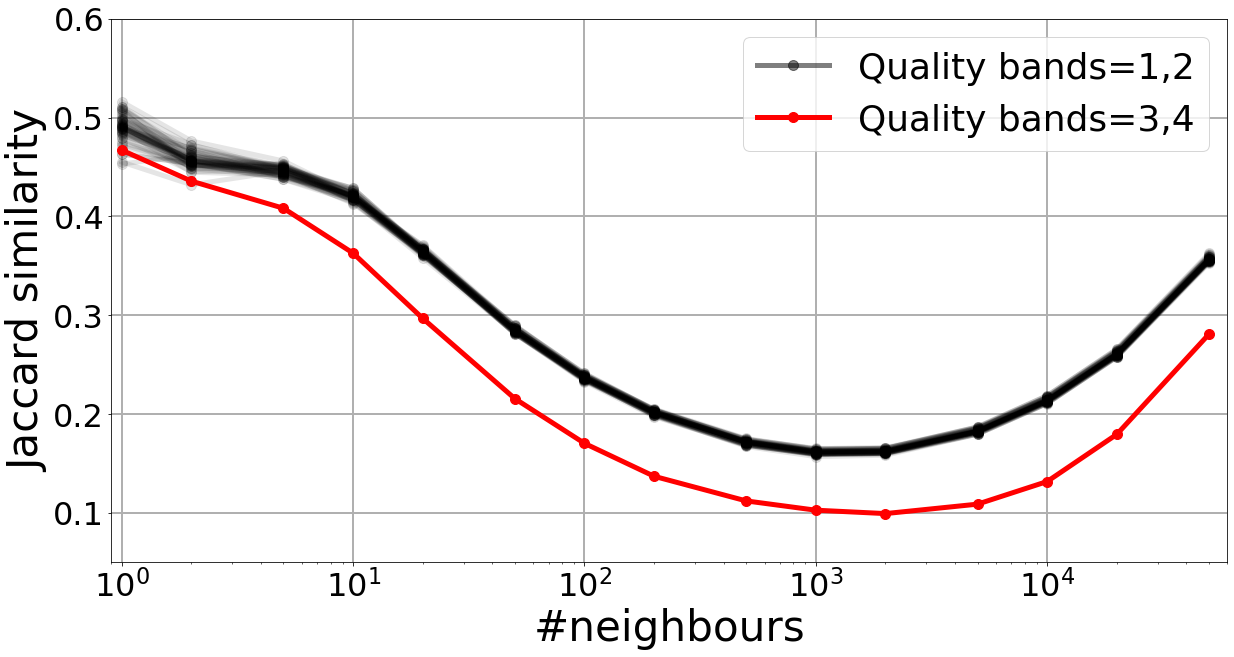

In [18]:
plt.figure(figsize=(20, 10))

plt.plot([-10, -9], [10, 10],
        c='k', alpha=0.5,
        marker='o', markersize=10,
        lw=5,
        label='Quality bands=1,2')

plt.plot(neigh_jaccard_bands_1_2[0][:, 0], neigh_jaccard_bands_1_2[0][:, 1],
        c='k', alpha=0.1,
        marker='o', markersize=10,
        lw=5)

for i in range(1, 50):
    plt.plot(neigh_jaccard_bands_1_2[i][:, 0], neigh_jaccard_bands_1_2[i][:, 1],
                 #np.std(neigh_jaccard_bands_1_2, axis=0)[:, 1],
                 c='k', alpha=0.1, #fmt='-o',
                 marker='o', markersize=10,
                 lw=5)
                 #label='Quality bands=1,2')

plt.plot(neigh_jaccard_bands_3_4[:, 0], neigh_jaccard_bands_3_4[:, 1], 
         'r-o', alpha=1.0, markersize=10,
         lw=5,
         label='Quality bands=3,4')

plt.grid(linewidth=2)
plt.xticks(size=32)
plt.yticks(size=32)
plt.xlabel("#neighbours", size=42)
plt.ylabel("Jaccard similarity", size=42)
plt.xscale("log")
plt.xlim(0.9, 60000)
plt.ylim(0.05, 0.6)

plt.legend(prop={'size': 36})
plt.show()
#plt.xlim(0, 20000)

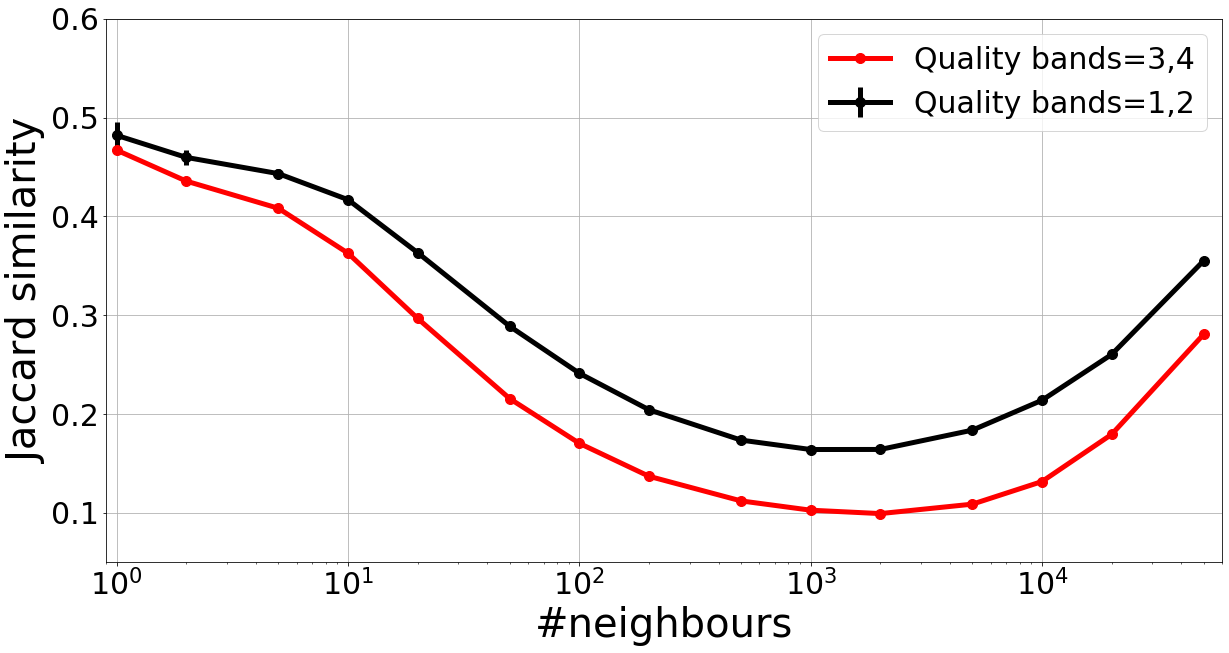

In [14]:
plt.figure(figsize=(20, 10))

plt.errorbar(neigh_jaccard_bands_1_2[i][:, 0], neigh_jaccard_bands_1_2[i][:, 1],
             np.std(neigh_jaccard_bands_1_2, axis=0)[:, 1],
            c='k', alpha=1.0,
            marker='o', markersize=10,
            lw=5,
            label='Quality bands=1,2')

plt.plot(neigh_jaccard_bands_3_4[:, 0], neigh_jaccard_bands_3_4[:, 1], 
         'r-o', alpha=1.0, markersize=10,
         lw=5,
         label='Quality bands=3,4')

plt.grid()
plt.xticks(size=30)
plt.yticks(size=30)
plt.xlabel("#neighbours", size=40)
plt.ylabel("Jaccard similarity", size=40)
plt.xscale("log")
plt.xlim(0.9, 60000)
plt.ylim(0.05, 0.6)

plt.legend(prop={'size': 30})
plt.show()
#plt.xlim(0, 20000)

In [ ]:
plt.figure(figsize=(10, 5))

plt.errorbar(neigh_jaccard_bands_1_2[0][:, 0], np.mean(neigh_jaccard_bands_1_2, axis=0)[:, 1],
             np.std(neigh_jaccard_bands_1_2, axis=0)[:, 1],
             c='k', alpha=1.0, fmt='-o',
             #marker='o',
             lw=4,
             label='Quality bands=1,2')

plt.plot(neigh_jaccard_bands_3_4[:, 0], neigh_jaccard_bands_3_4[:, 1], 
         'r-o', alpha=1.0, 
         lw=4,
         label='Quality bands=3,4')

plt.grid()
plt.xticks(size=20)
plt.yticks(size=20)
plt.xlabel("#neighbours", size=24)
plt.ylabel("Jaccard similarity", size=24)
plt.xscale("log")
plt.xlim(0.9, 60000)
plt.ylim(0.05, 0.6)

plt.legend(prop={'size': 20})
plt.show()
#plt.xlim(0, 20000)